In [1]:
import pandas as pd 
import numpy as np

# Load your dataset
data = pd.read_csv("heart_Disease.csv")

# Remove rows with any missing values
data.dropna(inplace=True)
data.columns = data.columns.str.strip()
data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [2]:
datasets = data.copy()


In [3]:
np.random.seed(42)
missing_rate = 0.2  # 20% missing
missing_indices = datasets.sample(frac=missing_rate, random_state=42).index
datasets.loc[missing_indices, 'target'] = np.nan
datasets.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target      59
dtype: int64

In [4]:
#print(datasets.isnull().sum())
missing_indices = datasets[datasets['target'].isna()].index
y_TEST = data.loc[missing_indices, 'target']
print(y_TEST)

5      0
6      3
7      0
9      1
17     0
24     4
25     0
33     0
42     0
45     4
46     0
59     0
60     2
63     0
73     1
75     0
77     0
78     0
82     0
84     0
91     3
93     0
94     0
98     0
102    0
109    3
112    0
117    0
125    0
127    3
140    0
149    0
155    1
159    0
169    0
177    1
178    0
184    1
185    0
187    2
195    3
198    0
211    4
214    1
222    0
225    0
227    0
236    2
237    1
240    0
248    3
267    2
279    0
282    3
283    0
288    0
290    1
297    1
299    2
Name: target, dtype: int64


In [5]:
missing_data = datasets[datasets['target'].isna()]
non_missing_data = datasets[datasets['target'].notna()]

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
X_complete = non_missing_data.drop(columns=['target'])
y_complete = non_missing_data['target']
X_missing = missing_data.drop(columns=['target'])

# 1. Mean/Median Imputation

In [8]:
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')

**Fit on complete data and transform missing data**

In [9]:
mean_imputed = mean_imputer.fit_transform(y_complete.values.reshape(-1, 1))
median_imputed = median_imputer.fit_transform(y_complete.values.reshape(-1, 1))

**filling missing value in the missing_data 'target'**

In [10]:
missing_data_mean = missing_data.copy()
missing_data_mean['target'] = mean_imputer.transform(missing_data_mean['target'].values.reshape(-1, 1))

In [11]:
missing_data_median = missing_data.copy()
missing_data_median['target'] = median_imputer.transform(missing_data_median['target'].values.reshape(-1, 1))

In [12]:
datasets_mean_filled = pd.concat([non_missing_data, missing_data_mean]).sort_index()
datasets_median_filled = pd.concat([non_missing_data, missing_data_median]).sort_index()

**now compare with the original target value**

In [13]:
# Imputed 'target' values for missing rows
mean_pred = mean_imputer.transform(missing_data['target'].values.reshape(-1, 1))
median_pred = median_imputer.transform(missing_data['target'].values.reshape(-1, 1))

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Flatten predicted values
mean_pred_flat = mean_pred.flatten()
median_pred_flat = median_pred.flatten()
y_true = y_TEST.values

# Mean Imputation Errors
mae_mean = mean_absolute_error(y_true, mean_pred_flat)
rmse_mean = np.sqrt(mean_squared_error(y_true, mean_pred_flat))

# Median Imputation Errors
mae_median = mean_absolute_error(y_true, median_pred_flat)
rmse_median = np.sqrt(mean_squared_error(y_true, median_pred_flat))

# Display results
print("📊 Mean Imputation:")
print(f"MAE: {mae_mean:.2f}, \nRMSE: {rmse_mean:.2f}")

print("\n📊 Median Imputation:")
print(f"MAE: {mae_median:.2f}, \nRMSE: {rmse_median:.2f}")


📊 Mean Imputation:
MAE: 1.06, 
RMSE: 1.27

📊 Median Imputation:
MAE: 0.88, 
RMSE: 1.54


# 2. K-NN Imputation

In [15]:
knn_imputer = KNNImputer(n_neighbors=5)
# Combine features and target for k-NN imputation
knn_data = pd.concat([X_complete, y_complete], axis=1)
knn_imputed = knn_imputer.fit_transform(knn_data)
knn_imputed_scores = knn_imputed[-len(X_missing):, -1]

**filling missing value in dataset**

In [16]:
from sklearn.impute import KNNImputer

# Combine features and target (including missing target values!)
knn_input = datasets.copy()

# Apply KNN Imputer on full data
knn_imputer = KNNImputer(n_neighbors=5)
imputed_array = knn_imputer.fit_transform(knn_input)

# Create imputed DataFrame
imputed_datasets = pd.DataFrame(imputed_array, columns=datasets.columns, index=datasets.index)

# Extract only the imputed target for missing rows
datasets.loc[missing_indices, 'target'] = imputed_datasets.loc[missing_indices, 'target']

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = datasets.loc[missing_indices, 'target']
y_true = y_TEST  # original values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("📊 KNN Imputation Evaluation:")
print(f"✅ MAE : {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

📊 KNN Imputation Evaluation:
✅ MAE : 0.91
✅ RMSE: 1.29


# 3. MICE Imputation

In [17]:
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Define MICE Imputer with a stronger estimator
mice_imputer = IterativeImputer(
    estimator=GradientBoostingRegressor(n_estimators=100, random_state=42),
    max_iter=10,
    random_state=42
)

# 2. Combine features + target
mice_data = pd.concat([X_complete, y_complete], axis=1)

# 3. Fit-transform the complete data
mice_imputed = mice_imputer.fit_transform(mice_data)

# 4. Convert back to DataFrame for easy access
mice_imputed_df = pd.DataFrame(mice_imputed, columns=mice_data.columns, index=mice_data.index)

# 5. Train imputer again on full data (optional) and transform missing part
full_data = pd.concat([X_complete, X_missing])
mice_imputer.fit(mice_data)
missing_data_mice = pd.concat([X_missing, pd.Series([np.nan]*len(X_missing), name='target', index= X_missing.index)], axis=1)
mice_imputed_missing = mice_imputer.transform(missing_data_mice)
mice_imputed_scores = mice_imputed_missing[:, -1]



In [18]:
# 6. Evaluate against ground truth
mae_mice = mean_absolute_error(y_TEST, mice_imputed_scores)
rmse_mice = np.sqrt(mean_squared_error(y_TEST, mice_imputed_scores))

print("📊 MICE Imputation Evaluation (with GradientBoostingRegressor):")
print(f"✅ MAE : {mae_mice:.2f}")
print(f"✅ RMSE: {rmse_mice:.2f}")

📊 MICE Imputation Evaluation (with GradientBoostingRegressor):
✅ MAE : 0.69
✅ RMSE: 1.01


# 4. Random Forest Imputation

**prepare data**

In [19]:
# Features (X) and target (y) from non-missing data
X = non_missing_data.drop(columns=['target'])
y = non_missing_data['target']

# Features for missing data (to be imputed)
X_missing = missing_data.drop(columns=['target'])

# True values for missing data (y_TEST)
y_true = y_TEST  

**split non_missing_data into Train/ Validation Sets**

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Train the Model**

In [21]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**Evaluate on Validation Set**

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_val_pred = model.predict(X_val)
# Calculate MAE and MSE
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

# Manually calculate RMSE from MSE
rmse_val = np.sqrt(mse_val)

print("📊 Random Forest Imputation Evaluation:")
print(f"✅Validation MAE: {mae_val:.2f}")
print(f"✅Validation RMSE: {rmse_val:.2f}")

📊 Random Forest Imputation Evaluation:
✅Validation MAE: 0.72
✅Validation RMSE: 1.04


**Predict Missing Values & Compare with y_TEST**

In [23]:
y_missing_pred = model.predict(X_missing)

# Calculate metrics for missing data predictions
mae_missing = mean_absolute_error(y_true, y_missing_pred)
mse_missing = mean_squared_error(y_true, y_missing_pred)
rmse_missing = np.sqrt(mse_missing)

print(f"\n✅Imputation MAE (vs y_TEST): {mae_missing:.2f}")
print(f"✅Imputation RMSE (vs y_TEST): {rmse_missing:.2f}")


✅Imputation MAE (vs y_TEST): 0.59
✅Imputation RMSE (vs y_TEST): 0.91


🔍 Imputation Results Summary:
               Mean  Median       k-NN       MICE  Random Forest
count  5.900000e+01    59.0  59.000000  59.000000      59.000000
mean   9.621849e-01     0.0   0.932203   0.841487       0.747797
std    1.119753e-16     0.0   1.142659   0.908264       0.733170
min    9.621849e-01     0.0   0.000000  -0.250972       0.010000
25%    9.621849e-01     0.0   0.000000   0.143768       0.145000
50%    9.621849e-01     0.0   0.000000   0.622031       0.360000
75%    9.621849e-01     0.0   2.000000   1.282686       1.225000
max    9.621849e-01     0.0   4.000000   3.634182       2.990000


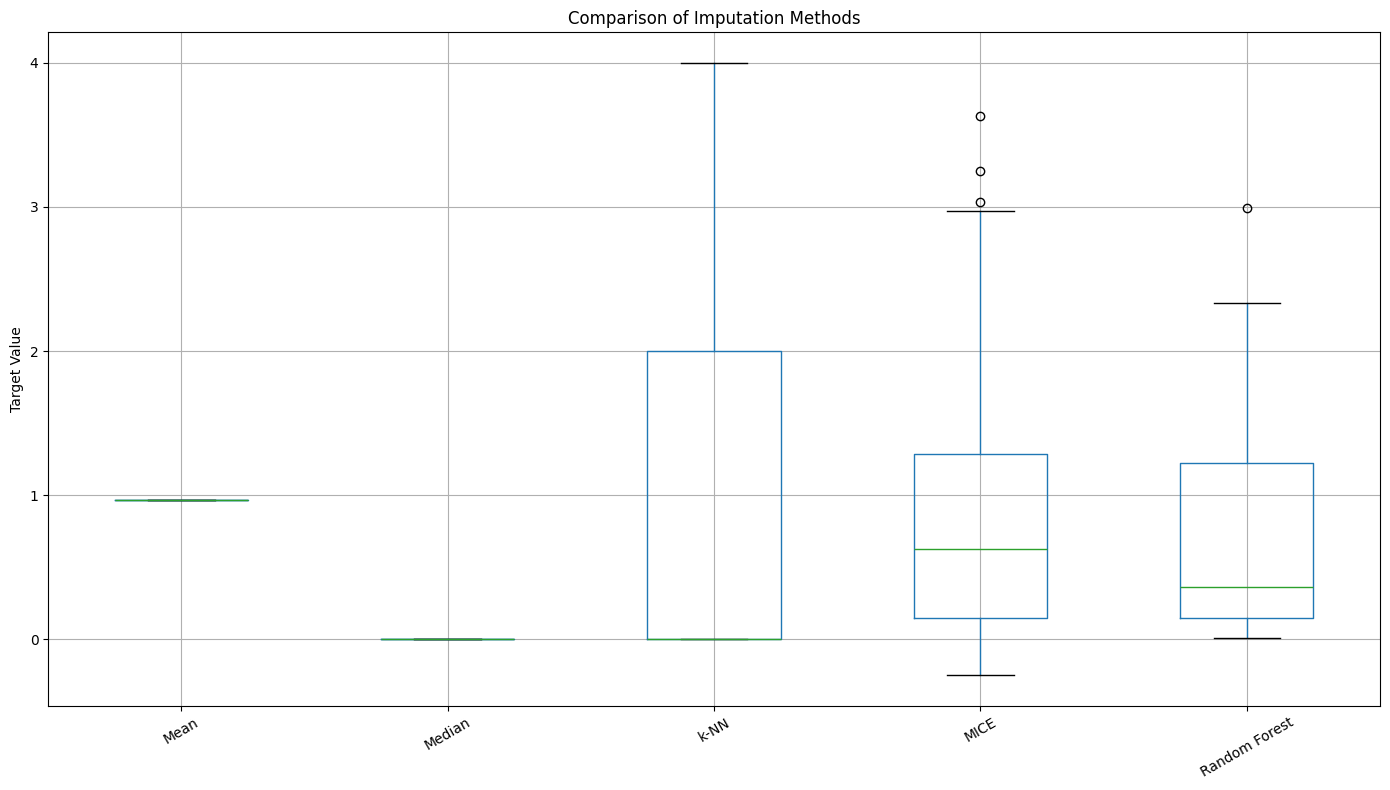

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a results DataFrame comparing all methods
results = pd.DataFrame({
    'Mean': mean_pred[:len(X_missing)].flatten(),
    'Median': median_pred[:len(X_missing)].flatten(),
    'k-NN': knn_imputed_scores,
    'MICE': mice_imputed_scores,
    'Random Forest': y_missing_pred 
    
})

# Summary statistics
print("🔍 Imputation Results Summary:")
print(results.describe())

# Visualization using box plot
plt.figure(figsize=(14, 8))
results.boxplot()
plt.title("Comparison of Imputation Methods")
plt.ylabel("Target Value")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_19316\1157699929.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19316\1157699929.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


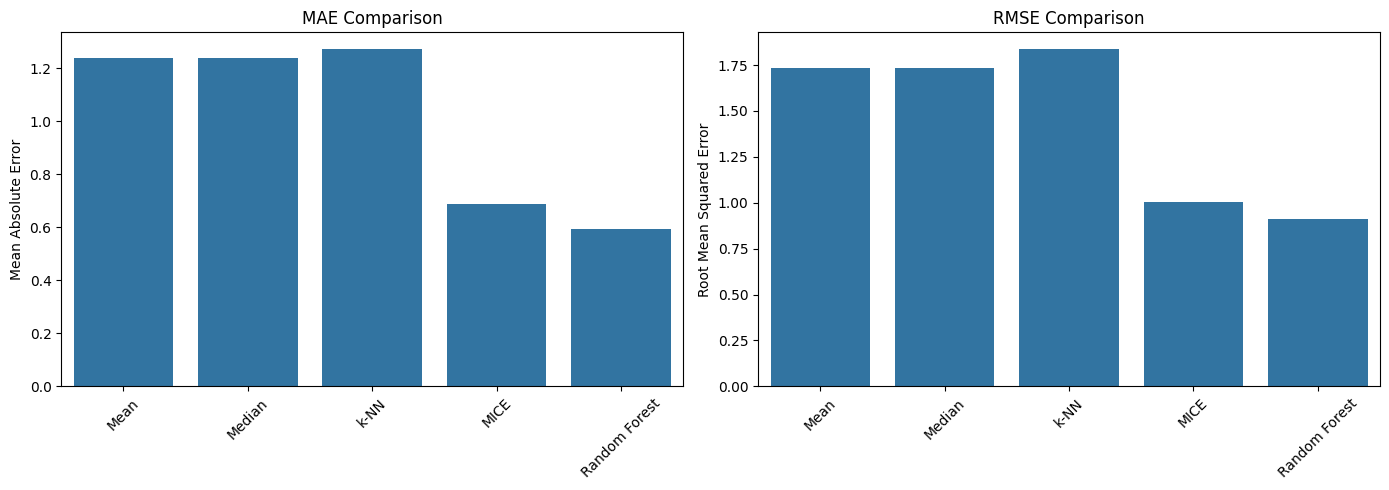

In [25]:
import seaborn as sns   
# Define MAE and RMSE values for each model
mae_scores = {
    'Mean': mean_absolute_error(y_TEST, mean_imputed[:len(y_TEST)].flatten()),
    'Median': mean_absolute_error(y_TEST, median_imputed[:len(y_TEST)].flatten()),
    'k-NN': mean_absolute_error(y_TEST, knn_imputed_scores),
    'MICE': mean_absolute_error(y_TEST, mice_imputed_scores),
    'Random Forest': mean_absolute_error(y_TEST, y_missing_pred),
    
}

rmse_scores = {
    'Mean': np.sqrt(mean_squared_error(y_TEST, mean_imputed[:len(y_TEST)].flatten())),
    'Median': np.sqrt(mean_squared_error(y_TEST, median_imputed[:len(y_TEST)].flatten())),
    'k-NN': np.sqrt(mean_squared_error(y_TEST, knn_imputed_scores)),
    'MICE': np.sqrt(mean_squared_error(y_TEST, mice_imputed_scores)),
    'Random Forest': np.sqrt(mean_squared_error(y_TEST, y_missing_pred)),
    
}

# Bar plots for MAE and RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()), ax=axes[0])
axes[0].set_title('MAE Comparison')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x=list(rmse_scores.keys()), y=list(rmse_scores.values()), ax=axes[1])
axes[1].set_title('RMSE Comparison')
axes[1].set_ylabel('Root Mean Squared Error')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()
